## Multimodal Training Sequential

Predict horizon boundaries from full images and geo-temporal infos. Afterwards, predict morphological features and symbol for every horizon

In [1]:
import os
import pickle

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_  # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
from tqdm import tqdm

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('./BGR')
import bgr.soil.datasets as bgr_data
import bgr.soil.models as bgr_mod
from bgr.soil.callbacks import EarlyStopping
from bgr.soil.metrics import DepthMarkerLoss

In [3]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
path_pictures = "../data/BGR/Profilbilder_no_ruler_no_sky/"
#path_pictures = "../data/BGR/Horizonte/"

### Data Loading

In [4]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Horizontsymbol'])
print(len(df.index))
df#.head()

15207
15206


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.rename(columns={"relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole": "relevanter Anteil"}, inplace=True)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [6]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Apply the simplification function to each row of the 'Horizontsymbol' column
col_name = "relevanter Anteil" # try to predict 'relevanter Anteil' first; otherwise, resort to 'stark vereinfacht'
df['Horizontsymbol_relevant'] = df['Horizontsymbol'].apply(lambda x: bgr_data.simplify_string(x, df_simple, col_name))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_relevant')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


#### Join images and further tables

In [7]:
# Read image dataset and add file path as extra column to df
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float) # for error 'list index out of range', delete @eaDir
#img_files['HorizontID'] = img_files['file'].str.split('.').map(lambda x: x[0][-1]).astype(float) # uncomment only for segmented horizon patches
img_files.head(15)

,file,Point
0,BB_0896_Y_1.JPG,896.0
1,BB_0903_Y_1.JPG,903.0
2,BW_4930_Y_1.JPG,4930.0
3,BW_5183_Y_1.JPG,5183.0
4,BW_5462_Y_1.JPG,5462.0
5,BY_3651_Y_1.JPG,3651.0
6,BY_3934_Y_1.JPG,3934.0
7,BY_3979_Y_1.JPG,3979.0
8,BY_4039_Y_1.JPG,4039.0
9,BY_4302_Y_1.JPG,4302.0


In [8]:
df = pd.merge(df, img_files, how='inner', on=['Point']) # for full images
#df = pd.merge(df, img_files, how='inner', on=['Point', 'HorizontID']) # for patches
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
print(len(df))
df.head(15)

16316


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,file
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
5,3.0,1.0,0.0,12.0,I; tbSw-Ah,tSw-Ah,Ls3,10YR 4/2,0.0,C0,h3,Wf6,NaN,SH,7.0,NaN,BB_0661.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
6,3.0,2.0,12.0,30.0,I; tbSw-rAp,tSw-Ap,Ls2,10YR 4/2,0.0,C0,h2,Wf4,NaN,SH,8.0,NaN,BB_0662.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
7,3.0,3.0,30.0,54.0,I; tbrGo-Sw,tGo-Sw,Ls4,2.5Y 5/1,0.0,C0,h1,Wf2,NaN,SH,10.0,NaN,BB_0663.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
8,3.0,4.0,54.0,125.0,I; tbGo-Sd,tGo-Sd,Lu,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,11.0,NaN,BB_0718.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
9,3.0,5.0,125.0,160.0,II; tmGor,tGor,Su3,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,12.0,NaN,BB_0720.0,110.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...


**Note**: When merging with the image dataset, the total dataframe increases in size, because some soil pictures were taken from more than one angle. These are still not duplicates, although the table features are the same for every such image.

In [9]:
# Join with annotator ids
#df_k = pd.read_csv(path_csv_annotator_ids)
#df_k = df_k.rename({'PointID':'Point'},axis=1)
#df_k.head()

In [10]:
#df = pd.merge(df, df_k, how='inner', on='Point')
#len(df)

**Note**: When joining with the annotator ids, the size of df decreases, since we don't have this id for every sample in the df.

In [11]:
# Join with table containing geographical infos
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
print(len(df_loc))
df_loc.head()

3106


,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [12]:
# There are some string artifacts when reading the Standort dataframe. Set them to NaN and remove the rows
df_loc['Point'] = pd.to_numeric(df_loc['Point'], errors='coerce')
df_loc = df_loc.dropna(subset=['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')
len(df)

16316

**Note** Size of df stays the same after merging with df_loc (Points in df_loc are all contained in Points df).

In [13]:
# Decide on which columns to keep for training
keep_columns = ['Point', #'HorizontID',
                'Obergrenze', 'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_relevant',
                #'Horizont_cluster',
                'Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung',
                #'max_depth', # not needed for training (and also has mostly NaNs)
                'file',
                #'Aufnehmer', # only when merged with annotators
                'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'GrundwaStand', 'Moormaechtigkeit',
                'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100']
df = df[keep_columns]
df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
df['ycoord'] = df['ycoord'].astype(float)
df

,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,28.0,54.0,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
2,2.0,54.0,68.0,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
3,2.0,68.0,96.0,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
4,2.0,96.0,201.0,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,6211.0,70.0,100.0,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16312,6211.0,100.0,130.0,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16313,6211.0,100.0,130.0,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16314,6211.0,130.0,155.0,Gr,fSms,2.5Y 5/4,1.0,C0,h0,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72


In [14]:
# Profile images only show horizons up to ~1 meter depth
# Note: Filter only necessary when joining table with whole images, not horizon segments
df = df[df['Obergrenze'] < 100]
len(df)

13621

#### Imputation

In [15]:
# Replace some of the missing values with recommendations from geology
df['Steine'] = df['Steine'].fillna(0.0)
df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
df['Durchwurzelung'] = df['Durchwurzelung'].str.split(',').str[0] # Some values have double labels; only keep the first one
df['Exposition'] = df['Exposition'].replace(['0', '---'], 'KE') # KE = Keine
df.loc[df['Exposition'].isna() & (df['Neigung'] == 'N0'), 'Exposition'] = 'KE' # NaN-Exposition should be 'KE', when Neigung is N0 (there will still be some other NaNs in Exposition

/tmp/ipykernel_979707/1919224170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Steine'] = df['Steine'].fillna(0.0)
/tmp/ipykernel_979707/1919224170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
/tmp/ipykernel_979707/1919224170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

#### Features and Labels Encoding

In [16]:
target = 'Horizontsymbol_relevant' #'Horizont_cluster'
num_features   = ['xcoord','ycoord', 'Steine', 'GrundwaStand', 'Moormaechtigkeit', 'Torfmaechtigkeit', 'KV_0_30', 'KV_30_100']
categ_features = ['Probenahme_Monat', 'Probenahme_Jahr',
                  'Bodenart', 'Bodenfarbe', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'Bodenklimaraum_Name',
                  'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'Neigung',
                  'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief']
feature_columns = num_features + categ_features

In [17]:
counts = df[target].value_counts()
counts

Horizontsymbol_relevant
Ap         2399
Ah          742
Bv          546
Sd          483
Go          403
           ... 
Bsh-Bv        1
ilC+Ap        1
M-Gkso        1
aAh°Gor       1
aAcp2         1
Name: count, Length: 1568, dtype: int64

In [18]:
# If already computed, load the HCE embeddings for the labels (see Label_Graph.ipynb)
with open('./BGR/label_embeddings/all_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)
print(np.shape(emb_dict['embedding']))
emb_dict

(87, 61)


{'ind2label': ['ilC',
  'Ael',
  'Sd',
  'C.',
  'imCv',
  'E.',
  'emC',
  'cC',
  'clC',
  'ilCbtv',
  'aelC',
  'Cv',
  'Bsh',
  'Axh',
  'Bhv',
  'P.',
  'Bvt',
  'Acxh',
  'Gro',
  'iC',
  'tGro',
  'Go',
  'Ap',
  'Gw',
  'Aep',
  'cmC',
  'imC',
  'Ssw',
  'Mc',
  'Hw',
  'Acp',
  'mCv',
  'Bv',
  'Sswd',
  'elC',
  'lC',
  'Aeh',
  'Bhs',
  'Cj',
  'tGr',
  'Axp',
  'bE',
  'Gr',
  'Gkso',
  'Gor',
  'M.',
  'Bsv',
  'Sw',
  'Bt',
  'Bcv',
  'Btv',
  'Hr',
  'Hv',
  'elCc',
  'Bs',
  'R.',
  'tGo',
  'Bh',
  'Ah',
  'Cbtv',
  'Al',
  'Sw-Bv',
  'Bv-ilC',
  'Bt-Sd',
  'Bv-Cv',
  'Sd-ilC',
  'Al-Sw',
  'Al-Bv',
  'M-Go',
  'Ael-Bt',
  'Ah-Bv',
  'Sw-M',
  'Sw-Ap',
  'Bv-Ael',
  'Go-ilC',
  'elC-P',
  'Sd-Bv',
  'Sw-ilC',
  'Al-Bt',
  'Sw-Ah',
  'P-Sd',
  'Sd-lC',
  'Sw-Go',
  'Sw-Bt',
  'Sd-Btv',
  'Bv-elC',
  'M-Gro'],
 'label2ind': {'ilC': 0,
  'Ael': 1,
  'Sd': 2,
  'C.': 3,
  'imCv': 4,
  'E.': 5,
  'emC': 6,
  'cC': 7,
  'clC': 8,
  'ilCbtv': 9,
  'aelC': 10,
  'Cv': 11,
  '

In [19]:
# For HCE: create separate dict where labels made out only of main symbols are stripped of the full stop '.'
# Note: We will use the label indexes from the embedding dictionary instead of a new sparse one-hot encoding to ease access to the embedding vectors during training via the original indexes from the emb_dict
dict_mapping = {}
for key, value in emb_dict['label2ind'].items():
    dict_mapping[key.strip('.')] = value
dict_mapping

{'ilC': 0,
 'Ael': 1,
 'Sd': 2,
 'C': 3,
 'imCv': 4,
 'E': 5,
 'emC': 6,
 'cC': 7,
 'clC': 8,
 'ilCbtv': 9,
 'aelC': 10,
 'Cv': 11,
 'Bsh': 12,
 'Axh': 13,
 'Bhv': 14,
 'P': 15,
 'Bvt': 16,
 'Acxh': 17,
 'Gro': 18,
 'iC': 19,
 'tGro': 20,
 'Go': 21,
 'Ap': 22,
 'Gw': 23,
 'Aep': 24,
 'cmC': 25,
 'imC': 26,
 'Ssw': 27,
 'Mc': 28,
 'Hw': 29,
 'Acp': 30,
 'mCv': 31,
 'Bv': 32,
 'Sswd': 33,
 'elC': 34,
 'lC': 35,
 'Aeh': 36,
 'Bhs': 37,
 'Cj': 38,
 'tGr': 39,
 'Axp': 40,
 'bE': 41,
 'Gr': 42,
 'Gkso': 43,
 'Gor': 44,
 'M': 45,
 'Bsv': 46,
 'Sw': 47,
 'Bt': 48,
 'Bcv': 49,
 'Btv': 50,
 'Hr': 51,
 'Hv': 52,
 'elCc': 53,
 'Bs': 54,
 'R': 55,
 'tGo': 56,
 'Bh': 57,
 'Ah': 58,
 'Cbtv': 59,
 'Al': 60,
 'Sw-Bv': 61,
 'Bv-ilC': 62,
 'Bt-Sd': 63,
 'Bv-Cv': 64,
 'Sd-ilC': 65,
 'Al-Sw': 66,
 'Al-Bv': 67,
 'M-Go': 68,
 'Ael-Bt': 69,
 'Ah-Bv': 70,
 'Sw-M': 71,
 'Sw-Ap': 72,
 'Bv-Ael': 73,
 'Go-ilC': 74,
 'elC-P': 75,
 'Sd-Bv': 76,
 'Sw-ilC': 77,
 'Al-Bt': 78,
 'Sw-Ah': 79,
 'P-Sd': 80,
 'Sd-lC': 81,
 '

In [20]:
# Replace '+' with '-' in the target column (see Label_Graph.ipynb)
df[target] = df[target].str.replace('+', '-', regex=False)
df[target] = df[target].str.replace('°', '-', regex=False) # also these, so that there is only one type of mixtures (the minus-mixture)
# Remove trailing numbers from the labels in the target column (they only account for how often the horizon is seen in the same picture)
df[target] = df[target].str.replace(r'\d+$', '', regex=True)

/tmp/ipykernel_979707/1744044841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].str.replace('+', '-', regex=False)
/tmp/ipykernel_979707/1744044841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].str.replace('°', '-', regex=False) # also these, so that there is only one type of mixtures (the minus-mixture)
/tmp/ipykernel_979707/1744044841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [21]:
# Map rare labels to frequent labels via Levenshtein distance
# Any better ideas? Sometimes the mapping is not very faithful to geological meaning
from jellyfish import levenshtein_distance as ld
rare_labels_mapping = {}
list_dict_mapping = list(dict_mapping.keys())
for lab in df[target].unique():
    if lab in list_dict_mapping:
        rare_labels_mapping[lab] = lab # for applying the map later in the df, we need the identity mappings as well
    else:
        similarities = [ld(lab, freq_lab) for freq_lab in list_dict_mapping]
        best_match = list_dict_mapping[np.argmin(similarities)]
        rare_labels_mapping[lab] = best_match
rare_labels_mapping

{'Ap': 'Ap',
 'E': 'E',
 'Bv': 'Bv',
 'Bv-ilC': 'Bv-ilC',
 'ilC': 'ilC',
 'tSw-Ah': 'Sw-Ah',
 'tSw-Ap': 'Sw-Ap',
 'tGo-Sw': 'tGo',
 'tGo-Sd': 'tGo',
 'Sw-tAp': 'Sw-Ap',
 'tSq': 'Sd',
 'tGro': 'tGro',
 'Aeh': 'Aeh',
 'Aep': 'Aep',
 'oCv': 'Cv',
 'fOh': 'Bsh',
 'Ae': 'Ael',
 'Bsh-Go': 'Bsh',
 'Bs-Go': 'M-Go',
 'R-Ah': 'Ah',
 'R-Gso-Gr': 'Gor',
 'R-Gr-Gso': 'M-Gro',
 'R-Go-Gso': 'Gkso',
 'tbSq': 'Sd',
 'tGor': 'tGr',
 'tAp-Go': 'tGo',
 'Ah-ilCv': 'Bv-ilC',
 'Aeh-Go': 'Aeh',
 'Bs-Gw': 'Bsh',
 'Go-Bhs': 'Bhs',
 'Go-Ap': 'Sw-Ap',
 'Go': 'Go',
 'Gor': 'Gor',
 'Gr': 'Gr',
 'Gw': 'Gw',
 'ilC-Bsh-Bs': 'ilC',
 'Bhs-ilC': 'Bv-ilC',
 'M': 'M',
 'tAp': 'Ap',
 'tGo': 'tGo',
 'Hw': 'Hw',
 'fnHr': 'Hr',
 'tGo-Ap': 'tGo',
 'Gro': 'Gro',
 'Bh-Gw': 'Bhv',
 'Bhs-Bs': 'Bhs',
 'Bhs-Go': 'Bhs',
 'Bhs': 'Bhs',
 'Sw-Bs': 'Sw-Bv',
 'Sd': 'Sd',
 'Sw': 'Sw',
 'Ap-Al': 'Ael',
 'Bt-Sd': 'Bt-Sd',
 'Al-Sw': 'Al-Sw',
 'Ah': 'Ah',
 'Swd': 'Sd',
 'Bh-Aeh': 'Bv-Ael',
 'Bsh': 'Bsh',
 'Bs': 'Bs',
 'Bbs-ilCv': 'Bv-ilC',
 'Bb

In [22]:
len(rare_labels_mapping)
# ToDo: manually correct the weird mappings
# Note: maybe use a second string distance to decide the winner, in case of a tie?

1218

In [23]:
# Map rare labels onto frequent labels
df[target] = df[target].map(rare_labels_mapping)
df

/tmp/ipykernel_979707/3489057721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].map(rare_labels_mapping)


,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
1,2.0,28.0,54.0,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
2,2.0,54.0,68.0,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
3,2.0,68.0,96.0,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
4,2.0,96.0,201.0,ilC,mSfs,10YR 7/4,1.0,C0,h0,Wf0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,6211.0,27.0,50.0,Bhs,fSms,5YR 3/2,1.0,C0,h2,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,KE,GG,TSF,T,117.59,87.72
16308,6211.0,50.0,70.0,Bsh,fSms,5YR 4/3,1.0,C0,h1,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,KE,GG,TSF,T,117.59,87.72
16309,6211.0,50.0,70.0,Bsh,fSms,5YR 4/3,1.0,C0,h1,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,KE,GG,TSF,T,117.59,87.72
16310,6211.0,70.0,100.0,Go-ilC,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,KE,GG,TSF,T,117.59,87.72


In [24]:
# One-hot encoding of the target column
#bgr_data.encode_categorical_columns(df, target) # for standard one-hot vectors of the targets
df[target] = df[target].map(dict_mapping) # in conjunction with HCEs
df[target] = df[target].astype(int)
df.head(5)

/tmp/ipykernel_979707/1051670463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].map(dict_mapping) # in conjunction with HCEs
/tmp/ipykernel_979707/1051670463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].astype(int)


,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,22,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
1,2.0,28.0,54.0,5,Sl2,10YR 3/3,3.0,C0,h2,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
2,2.0,54.0,68.0,32,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
3,2.0,68.0,96.0,62,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
4,2.0,96.0,201.0,0,mSfs,10YR 7/4,1.0,C0,h0,Wf0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19


In [25]:
# Encode categorical features (NaNs are left NaNs)
for categ in categ_features:
    bgr_data.encode_categorical_columns(df, categ)
df

/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,22,3.0,24.0,3.0,0,1.0,4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,247,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.89,54.19
1,2.0,28.0,54.0,5,3.0,0.0,3.0,0,3.0,3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,247,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.89,54.19
2,2.0,54.0,68.0,32,3.0,20.0,10.0,0,2.0,3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,247,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.89,54.19
3,2.0,68.0,96.0,62,8.0,72.0,1.0,0,0.0,1,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,247,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.89,54.19
4,2.0,96.0,201.0,0,7.0,37.0,1.0,0,0.0,0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,247,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,6211.0,27.0,50.0,37,8.0,68.0,1.0,0,3.0,3,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,8,42,1.0,110.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,117.59,87.72
16308,6211.0,50.0,70.0,12,8.0,38.0,1.0,0,2.0,1,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,8,42,1.0,110.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,117.59,87.72
16309,6211.0,50.0,70.0,12,8.0,38.0,1.0,0,2.0,1,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,8,42,1.0,110.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,117.59,87.72
16310,6211.0,70.0,100.0,74,8.0,19.0,1.0,0,2.0,6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,8,42,1.0,110.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,117.59,87.72


In [26]:
# Some columns still have NaNs
# For now, we are replacing the missing values with the column medians
# Any better ideas? In particular the column GrundwaStand has quite a few missing entries...
df.info()
df = df.fillna(df.median(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
Index: 13621 entries, 0 to 16311
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Point                    13621 non-null  float64
 1   Obergrenze               13621 non-null  float64
 2   Untergrenze              13621 non-null  float64
 3   Horizontsymbol_relevant  13621 non-null  int64  
 4   Bodenart                 13589 non-null  float64
 5   Bodenfarbe               13572 non-null  float64
 6   Steine                   13621 non-null  float64
 7   Karbonat                 13621 non-null  int64  
 8   Humusgehaltsklasse       13615 non-null  float64
 9   Durchwurzelung           13621 non-null  int64  
 10  file                     13621 non-null  object 
 11  Probenahme_Monat         13621 non-null  int64  
 12  Probenahme_Jahr          13621 non-null  int64  
 13  xcoord                   13621 non-null  float64
 14  ycoord                   13

In [27]:
len(df['Point'].unique()) # number of unique images

3101

### Training

In [28]:
# Split variables into different categories according to their roles in the sequential training
soil_infos = ['Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung']#, 'max_depth', 'HorizontID']

geotemp_img_infos = [#'Point',
                     'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name', 'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'GrundwaStand',
                     'Moormaechtigkeit', 'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100',
                     'file']

depth_markers = ['Obergrenze', 'Untergrenze']

# horizon symbols already in 'target' (see above)

In [29]:
# The dataframe has one row per horizon
# For sequential training, make it one row per full image (the depth markers and the morphological features will be stored as lists and used later as ground truth in training)
df = df.groupby('file', as_index=False).agg({     # Group by images, not by Point, since there are sometimes several images (different angles) for the same Point
    **{gt: 'first' for gt in geotemp_img_infos},  # Take the first value (all are the same for each image, including the image path)
    'Untergrenze': list,                          # Combine depth markers into a list (only lower bound Untergrenze actually needed)
    **{st: list for st in soil_infos},            # Combine tabular features into lists (in the order of the horizons top to bottom)
    target: list
}).reset_index()
geotemp_img_infos = ['index'] + geotemp_img_infos # Add the new index column
                                                  # Used only for accessing the morphological features in the dataframe
                                                  # (they have different shapes and cannot be stacked in tensor batches)
df

,index,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100,file,Untergrenze,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Horizontsymbol_relevant
0,0,1,7,819021.7488,5941699.083,7,0,0,12,770,0.0,200.0,0.0,0.0,3.0,1.0,1.0,0.0,1.0,38.60,21.42,../data/BGR/Profilbilder_no_ruler_no_sky/BB_05...,"[30.0, 38.0, 50.0, 200.0]","[3.0, 3.0, 10.0, 12.0]","[1.0, 1.0, 10.0, 5.0]","[2.0, 2.0, 4.0, 4.0]","[0, 0, 0, 0]","[3.0, 3.0, 0.0, 0.0]","[3, 3, 1, 2]","[22, 22, 73, 76]"
1,1,1,6,819307.3864,5935183.595,7,0,0,11,371,0.0,200.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,34.91,11.67,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[29.0, 40.0, 54.0, 60.0, 80.0, 201.0]","[11.0, 11.0, 6.0, 10.0, 3.0, 21.0]","[4.0, 5.0, 29.0, 30.0, 42.0, 75.0]","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0]","[2, 0, 2, 5, 7, 5]","[1.0, 2.0, 2.0, 2.0, 2.0, 0.0]","[4, 3, 1, 1, 1, 0]","[22, 65, 65, 81, 81, 81]"
2,2,8,6,826424.5503,5932240.596,7,0,0,10,22,0.0,200.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,42.21,34.56,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[28.0, 50.0, 74.0, 110.0]","[10.0, 11.0, 11.0, 11.0]","[0.0, 0.0, 3.0, 3.0]","[4.0, 4.0, 4.0, 4.0]","[0, 0, 7, 7]","[1.0, 3.0, 2.0, 0.0]","[4, 3, 3, 1]","[40, 13, 34, 34]"
3,3,4,6,807568.3913,5926533.227,7,0,0,12,44,0.0,200.0,0.0,0.0,4.0,5.0,2.0,14.0,3.0,37.39,13.22,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[30.0, 47.0, 73.0, 102.0]","[2.0, 2.0, 3.0, 3.0]","[0.0, 10.0, 13.0, 16.0]","[4.0, 4.0, 2.0, 2.0]","[0, 0, 0, 0]","[1.0, 2.0, 0.0, 0.0]","[3, 1, 1, 2]","[22, 1, 69, 78]"
4,4,1,6,818608.7036,5925050.271,7,0,0,7,413,2.0,200.0,0.0,0.0,3.0,5.0,0.0,4.0,1.0,48.47,16.43,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[33.0, 43.0, 71.0, 88.0, 100.0]","[28.0, 7.0, 2.0, 20.0, 10.0]","[0.0, 15.0, 54.0, 44.0, 14.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0]","[1.0, 2.0, 2.0, 0.0, 0.0]","[3, 0, 0, 0, 0]","[22, 0, 65, 0, 68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,3342,0,6,648389.8108,5588119.501,10,1,0,0,616,0.0,200.0,0.0,0.0,8.0,7.0,7.0,0.0,3.0,48.82,2.46,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[14.0, 40.0, 60.0, 93.0]","[15.0, 15.0, 26.0, 26.0]","[6.0, 5.0, 53.0, 53.0]","[60.0, 75.0, 90.0, 90.0]","[0, 0, 0, 0]","[1.0, 2.0, 0.0, 0.0]","[5, 3, 1, 2]","[22, 14, 62, 77]"
3343,3343,0,4,688216.3809,5588885.660,10,0,0,0,9,0.0,200.0,0.0,0.0,1.0,4.0,6.0,0.0,1.0,69.19,23.61,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[34.0, 69.0, 140.0]","[4.0, 4.0, 18.0]","[0.0, 3.0, 10.0]","[20.0, 30.0, 25.0]","[0, 0, 0]","[1.0, 2.0, 0.0]","[5, 3, 1]","[22, 32, 77]"
3344,3344,0,4,701551.6557,5587919.679,10,0,0,0,0,0.0,200.0,0.0,0.0,6.0,4.0,0.0,0.0,1.0,75.65,9.34,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[20.0, 27.0, 70.0, 100.0]","[15.0, 15.0, 15.0, 26.0]","[2.0, 2.0, 3.0, 23.0]","[15.0, 25.0, 60.0, 90.0]","[0, 0, 0, 0]","[1.0, 1.0, 2.0, 0.0]","[4, 1, 0, 0]","[22, 22, 32, 0]"
3345,3345,3,4,653547.6374,5581353.991,10,0,0,0,2,0.0,200.0,0.0,0.0,5.0,2.0,0.0,3.0,5.0,61.72,30.69,../data/BGR/Profilbilder_no_ruler_no_sky/TH_35...,"[31.0, 49.0, 71.0, 144.0]","[15.0, 15.0, 15.0, 33.0]","[1.0, 7.0, 5.0, 16.0]","[5.0, 5.0, 20.0, 25.0]","[0, 0, 0, 0]","[1.0, 2.0, 0.0, 0.0]","[3, 2, 2, 2]","[22, 32, 47, 2]"


In [30]:
# Only rows with Obergrenze < 100 were kept. This lead to some Untergrenze values still being above 100.
# Round these down to 100 for a correct loss calculation (see depth_marker_loss)
def modify_df_list(lst):
    lst[-1] = 100.0
    return lst
df['Untergrenze'] = df['Untergrenze'].apply(modify_df_list)
df

,index,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100,file,Untergrenze,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Horizontsymbol_relevant
0,0,1,7,819021.7488,5941699.083,7,0,0,12,770,0.0,200.0,0.0,0.0,3.0,1.0,1.0,0.0,1.0,38.60,21.42,../data/BGR/Profilbilder_no_ruler_no_sky/BB_05...,"[30.0, 38.0, 50.0, 100.0]","[3.0, 3.0, 10.0, 12.0]","[1.0, 1.0, 10.0, 5.0]","[2.0, 2.0, 4.0, 4.0]","[0, 0, 0, 0]","[3.0, 3.0, 0.0, 0.0]","[3, 3, 1, 2]","[22, 22, 73, 76]"
1,1,1,6,819307.3864,5935183.595,7,0,0,11,371,0.0,200.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,34.91,11.67,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[29.0, 40.0, 54.0, 60.0, 80.0, 100.0]","[11.0, 11.0, 6.0, 10.0, 3.0, 21.0]","[4.0, 5.0, 29.0, 30.0, 42.0, 75.0]","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0]","[2, 0, 2, 5, 7, 5]","[1.0, 2.0, 2.0, 2.0, 2.0, 0.0]","[4, 3, 1, 1, 1, 0]","[22, 65, 65, 81, 81, 81]"
2,2,8,6,826424.5503,5932240.596,7,0,0,10,22,0.0,200.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,42.21,34.56,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[28.0, 50.0, 74.0, 100.0]","[10.0, 11.0, 11.0, 11.0]","[0.0, 0.0, 3.0, 3.0]","[4.0, 4.0, 4.0, 4.0]","[0, 0, 7, 7]","[1.0, 3.0, 2.0, 0.0]","[4, 3, 3, 1]","[40, 13, 34, 34]"
3,3,4,6,807568.3913,5926533.227,7,0,0,12,44,0.0,200.0,0.0,0.0,4.0,5.0,2.0,14.0,3.0,37.39,13.22,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[30.0, 47.0, 73.0, 100.0]","[2.0, 2.0, 3.0, 3.0]","[0.0, 10.0, 13.0, 16.0]","[4.0, 4.0, 2.0, 2.0]","[0, 0, 0, 0]","[1.0, 2.0, 0.0, 0.0]","[3, 1, 1, 2]","[22, 1, 69, 78]"
4,4,1,6,818608.7036,5925050.271,7,0,0,7,413,2.0,200.0,0.0,0.0,3.0,5.0,0.0,4.0,1.0,48.47,16.43,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[33.0, 43.0, 71.0, 88.0, 100.0]","[28.0, 7.0, 2.0, 20.0, 10.0]","[0.0, 15.0, 54.0, 44.0, 14.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0]","[1.0, 2.0, 2.0, 0.0, 0.0]","[3, 0, 0, 0, 0]","[22, 0, 65, 0, 68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,3342,0,6,648389.8108,5588119.501,10,1,0,0,616,0.0,200.0,0.0,0.0,8.0,7.0,7.0,0.0,3.0,48.82,2.46,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[14.0, 40.0, 60.0, 100.0]","[15.0, 15.0, 26.0, 26.0]","[6.0, 5.0, 53.0, 53.0]","[60.0, 75.0, 90.0, 90.0]","[0, 0, 0, 0]","[1.0, 2.0, 0.0, 0.0]","[5, 3, 1, 2]","[22, 14, 62, 77]"
3343,3343,0,4,688216.3809,5588885.660,10,0,0,0,9,0.0,200.0,0.0,0.0,1.0,4.0,6.0,0.0,1.0,69.19,23.61,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[34.0, 69.0, 100.0]","[4.0, 4.0, 18.0]","[0.0, 3.0, 10.0]","[20.0, 30.0, 25.0]","[0, 0, 0]","[1.0, 2.0, 0.0]","[5, 3, 1]","[22, 32, 77]"
3344,3344,0,4,701551.6557,5587919.679,10,0,0,0,0,0.0,200.0,0.0,0.0,6.0,4.0,0.0,0.0,1.0,75.65,9.34,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[20.0, 27.0, 70.0, 100.0]","[15.0, 15.0, 15.0, 26.0]","[2.0, 2.0, 3.0, 23.0]","[15.0, 25.0, 60.0, 90.0]","[0, 0, 0, 0]","[1.0, 1.0, 2.0, 0.0]","[4, 1, 0, 0]","[22, 22, 32, 0]"
3345,3345,3,4,653547.6374,5581353.991,10,0,0,0,2,0.0,200.0,0.0,0.0,5.0,2.0,0.0,3.0,5.0,61.72,30.69,../data/BGR/Profilbilder_no_ruler_no_sky/TH_35...,"[31.0, 49.0, 71.0, 100.0]","[15.0, 15.0, 15.0, 33.0]","[1.0, 7.0, 5.0, 16.0]","[5.0, 5.0, 20.0, 25.0]","[0, 0, 0, 0]","[1.0, 2.0, 0.0, 0.0]","[3, 2, 2, 2]","[22, 32, 47, 2]"


In [31]:
# Get the lengths of the lists in the 'Untergrenze' column
list_lengths = df['Untergrenze'].apply(len)

min_length = list_lengths.min()
max_length = list_lengths.max()

print(f"Minimum number of horizons: {min_length}")
print(f"Maximum number of horizons: {max_length}")

Minimum number of horizons: 2
Maximum number of horizons: 8


In [32]:
min_length_list = df[df['Untergrenze'].apply(len) == min_length]['Untergrenze'].values[0]
max_length_list = df[df['Untergrenze'].apply(len) == max_length]['Untergrenze'].values[0]
print(f"List with minimum length: {min_length_list}")
print(f"List with maximum length: {max_length_list}")

List with minimum length: [32.0, 100.0]
List with maximum length: [13.0, 26.0, 40.0, 58.0, 68.0, 83.0, 98.0, 100.0]


In [33]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [34]:
# Initialize model
#num_classes = len(df[target].unique()) # for one-hot encoding
#num_classes = emb_dict['embedding'].shape[1] # for HCE (the dim. of final layer in the model should match the dim of the embedded label vectors)
model = bgr_mod.HorizonClassifier(geo_temp_input_dim=len(geotemp_img_infos)-1, # without counting the img path
                                  max_seq_len = max_length,                    # fixed from longest list of horizons in one image from dataset
                                  stop_token = 100)                            # End of Sequence Token at -100 meters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

HorizonClassifier(
  (image_encoder): ImageEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [35]:
# Data split
#train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)
train_df, val_df = train_test_split(df, random_state=2024)

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

2510 samples for training.
837 samples for validating.


In [36]:
# Define the image transforms for augmentation
augment = [
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
]

In [37]:
# Create Dataset object with image and tabular features
train_dataset = bgr_data.ImageTabularDataset(dataframe=train_df,#[:100],
                                             normalize=normalize,
                                             augment=augment,
                                             image_path='file',
                                             #label=depth_markers[1], # predict list of lower boundaries (Untergrenze)
                                             label=None, # no label column as input; access it instead via Point during training
                                             feature_columns=geotemp_img_infos[:-1])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16)

# Training parameters
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#criterion = nn.CrossEntropyLoss()
#criterion = TopKLoss(k=5)
#criterion = nn.CosineEmbeddingLoss() # for HCE: 1 - cos(prediction, target)
criterion = DepthMarkerLoss()

# Note: Is MSE better for HCE?

In [38]:
### Callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=1e-5, verbose=True)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)

In [39]:
print(f"Training size original: {len(train_dataset.dataframe)}")
print(f"Training size after augmentation: {len(train_dataset)}")

Training size original: 2510
Training size after augmentation: 7530


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0
tensor([1.7890e+03, 7.0000e+00, 0.0000e+00, 5.0506e+05, 5.8320e+06, 6.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+02,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 5.3780e+01, 1.5110e+01])
Image 1
tensor([1.7890e+03, 7.0000e+00, 0.0000e+00, 5.0506e+05, 5.8320e+06, 6.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+02,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 5.3780e+01, 1.5110e+01])
Image 2
tensor([1.7890e+03, 7.0000e+00, 0.0000e+00, 5.0506e+05, 5.8320e+06, 6.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+02,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 5.3780e+01, 1.5110e+01])


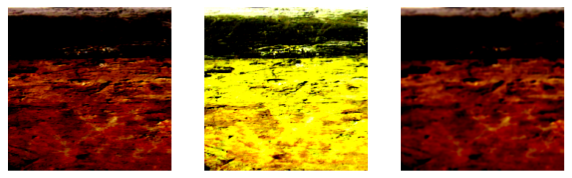

In [40]:
# Check an augmented subset
aug_images = []
for i in range(len(train_dataset)):
    image, tabular_features = train_dataset[i]
    aug_images.append(image)
    print(f"Image {i}")
    print(tabular_features)
    if i == 2: break

plt.figure(figsize=(10, 8))
for i in range(len(aug_images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
    plt.axis('off')

In [41]:
val_dataset = bgr_data.ImageTabularDataset(dataframe=val_df,#[:100],
                                           normalize=normalize,
                                           image_path='file',
                                           #label=depth_markers[1],
                                           label=None,
                                           feature_columns=geotemp_img_infos[:-1])

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=16)

In [42]:
#criterion = nn.CrossEntropyLoss()
criterion = DepthMarkerLoss()
#criterion = nn.MSELoss()

In [43]:
def pad_tensor(true_depths, max_seq_len, stop_token, device='cpu'):
    """true_depths is a list with lists of variable lengths.
    we turn it into a tensor of padded tensors."""
    padded_targets, masks = [], []

    for depths in true_depths:
        depth_len = len(depths)
        if depth_len > max_seq_len:
            depths = depths[:max_seq_len]
            depth_len = max_seq_len
        mask = [1] * depth_len + [0] * (max_seq_len - depth_len)
        depths = depths + [stop_token] * (max_seq_len - depth_len)
        padded_targets.append(torch.tensor(depths, device=device))
        masks.append(torch.tensor(mask, device=device))

    return torch.stack(padded_targets), torch.stack(masks)

In [44]:
model.train()
epochs = 10
lr_history, train_loss_history, val_loss_history = [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    train_loss_total = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, geotemp_features = batch
        images, geotemp_features = images.to(device), geotemp_features.to(device)

        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop

        # Predict depth markers (as padded tensors)
        pred_depths = model(image=images, geo_temp=geotemp_features)

        # Get corresponding true depth markers via index column in df (also the first value in every row in geotemp)
        true_depths = df[df['index'].isin(geotemp_features.cpu().numpy()[:,0])]['Untergrenze'].tolist()
        # Turn list of depths into a padded tensor and also return mask of valid positions
        padded_true_depths, true_masks = pad_tensor(true_depths,
                                                    max_seq_len=model.depth_marker_predictor.max_seq_len,
                                                    stop_token=model.depth_marker_predictor.stop_token,
                                                    device=device)

        train_loss = criterion(pred_depths, padded_true_depths, true_masks)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_total += train_loss.item()

        train_loader_tqdm.set_postfix(loss=train_loss.item())
        break

    avg_train_loss = train_loss_total / len(train_loader)
    break

Epoch 1/10


In [45]:
avg_train_loss

38.785259699417374

In [67]:
# Note: test whether batch.to(device) generates duplicates in the df
seen = set()
duplicates = []

for _, batch in train_loader_tqdm:

    for idx in batch[:,0]:  # Adjust this key depending on how 'index' is stored
        if idx in seen:
            duplicates.append(idx)
        else:
            seen.add(idx)

print(f"Duplicate indices: {duplicates}")

Duplicate indices: []


In [39]:
model.train()
epochs = 10
lr_history, train_loss_history, val_loss_history = [], [], []
train_acc_history, train_topk_acc_history, val_acc_history, val_topk_acc_history = [], [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    train_correct = 0
    train_topk_correct = 0
    train_loss_total = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop
        outputs = model(image=images, tabular_features=tabular_features)

        # Get corresponding embeddings from int-labels
        target_embeddings = torch.stack([torch.tensor(emb_dict['embedding'][lab]) for lab in labels]).to(device)
        # Create a dummy "same class" tensor with 1s for the cosine similarity
        same_class = torch.ones(outputs.size(0)).to(device)
        # Normalize both predictions and target embeddings
        # Note: rather normalize the mixture embeddings immediately after the linear combination of the parents?
        outputs = F.normalize(outputs, p=2, dim=1)
        target_embeddings = F.normalize(target_embeddings, p=2, dim=1)

        #train_loss = criterion(outputs, labels) # for cross entropy or top-k-loss (without HCE)
        train_loss = criterion(outputs, target_embeddings, same_class) # for cosine loss (with HCE)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate accuracy for this batch
        train_loss_total += train_loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        #train_correct += (predicted == labels).sum().item()
        #train_topk_correct += top_k_accuracy(outputs, labels, k=5)

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Calculate average training accuracy for the epoch
    #train_acc = train_correct / len(train_loader.dataset)
    #train_topk_acc = train_topk_correct / len(train_loader)
    avg_train_loss = train_loss_total / len(train_loader)

    # Evaluation loop
    model.eval()
    val_correct = 0
    val_topk_correct = 0
    val_loss_total = 0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, tabular_features, labels = batch
            images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
            outputs = model(image=images, tabular_features=tabular_features)

            # Get corresponding embeddings from int-labels
            target_embeddings = torch.stack([torch.tensor(emb_dict['embedding'][lab]) for lab in labels]).to(device)
            # Create a dummy "same class" tensor with 1s for the cosine similarity
            same_class = torch.ones(outputs.size(0)).to(device)
            # Normalize both predictions and target embeddings
            # Note: rather normalize the mixture embeddings immediately after the linear combination of the parents?
            outputs = F.normalize(outputs, p=2, dim=1)
            target_embeddings = F.normalize(target_embeddings, p=2, dim=1)

            #val_loss = criterion(outputs, labels) # for cross entropy or top-k-loss (without HCE)
            val_loss = criterion(outputs, target_embeddings, same_class) # for cosine loss (with HCE)

            val_loss_total += val_loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            #val_correct += (predicted == labels).sum().item()
            #val_topk_correct += top_k_accuracy(outputs, labels, k=5)

    # Calculate average val accuracy for the epoch
    #val_acc = val_correct / len(val_loader.dataset)
    #val_topk_acc = val_topk_correct / len(val_loader)
    avg_val_loss = val_loss_total / len(val_loader)

    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    #train_acc_history.append(train_acc); val_acc_history.append(val_acc)
    #train_topk_acc_history.append(train_topk_acc); val_topk_acc_history.append(val_topk_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")#, Training Accuracy: {train_acc:.4f}, Training Top {criterion.k} Accuracy: {train_topk_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")#, Validation Accuracy: {val_acc:.4f}, Validation Top {criterion.k} Accuracy: {val_topk_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/10


Epoch 1, Training Loss: 0.6659
Validation Loss: 0.5769
Current LR: 0.001
Epoch 2/10


Epoch 2, Training Loss: 0.5564
Validation Loss: 0.5395
Current LR: 0.001
Epoch 3/10


Epoch 3, Training Loss: 0.5335
Validation Loss: 0.5645
Current LR: 0.001
EarlyStopping: No improvement for 1 epochs.
Epoch 4/10


Epoch 4, Training Loss: 0.5397
Validation Loss: 0.5435
Current LR: 0.001
EarlyStopping: No improvement for 2 epochs.
Epoch 5/10


Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5, Training Loss: 0.5356
Validation Loss: 0.5405
Current LR: 0.0001
EarlyStopping: No improvement for 3 epochs.
Epoch 6/10


Epoch 6, Training Loss: 0.5191
Validation Loss: 0.5124
Current LR: 0.0001
Epoch 7/10


Epoch 7, Training Loss: 0.5015
Validation Loss: 0.5078
Current LR: 0.0001
EarlyStopping: No improvement for 1 epochs.
Epoch 8/10


Epoch 8, Training Loss: 0.4915
Validation Loss: 0.5040
Current LR: 0.0001
EarlyStopping: No improvement for 2 epochs.
Epoch 9/10


Epoch 9, Training Loss: 0.4825
Validation Loss: 0.5050
Current LR: 0.0001
EarlyStopping: No improvement for 3 epochs.
Epoch 10/10


Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
Epoch 10, Training Loss: 0.4732
Validation Loss: 0.5115
Current LR: 1e-05


### Evaluation

In [ ]:
plt.figure(figsize=(21, 6))

complete_epochs = len(train_acc_history)+1
plt.subplot(1, 3, 1)
plt.plot(range(1, complete_epochs), train_loss_history, label='Train Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_loss_history,  label='Validation Loss',  marker='o', color='r')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(range(1, complete_epochs), train_acc_history, label='Train Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_acc_history, label='Validation Accuracy', marker='o', color='r')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(range(1, complete_epochs), train_topk_acc_history, label=f'Train Top {criterion.k} Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_topk_acc_history, label=f'Validation Top {criterion.k} Accuracy', marker='o', color='r')
plt.title(f'Top {criterion.k} Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel(f'Top {criterion.k} Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, complete_epochs), lr_history, marker='o', linestyle='-', color='b')
plt.title("Learning Rate Evolution")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid()
plt.show()

In [ ]:
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = []
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    for batch in val_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs.append(model(image=images, tabular_features=tabular_features))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert outputs to predicted labels (adjust based on your model's output format)
predicted_probs, predicted_labels = [], []
for output in outputs:

    predicted_labels.extend(torch.argmax(output, dim=1).tolist())
    predicted_probs.extend(torch.softmax(output, dim=1).cpu().numpy()) # Convert logits to probabilities

# Convert true labels to a list
true_labels = [label.item() for batch in val_loader for label in batch[2]]

# Calculate metrics
report = classification_report(true_labels, predicted_labels)
print(report)

In [ ]:
# Compute PR curve for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

predicted_probs = np.array(predicted_probs)
true_labels = np.array(true_labels)
n_classes = predicted_probs.shape[1]
precision, recall, avg_precision = {}, {}, {}
# Binarize the labels (one-hot encoding for multiclass)
true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    avg_precision[i] = average_precision_score(true_labels_binarized[:, i], predicted_probs[:, i])

# Compute macro-average PR curve
precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_binarized.ravel(), predicted_probs.ravel())
avg_precision["macro"] = average_precision_score(true_labels_binarized, predicted_probs, average="macro")

In [ ]:
plt.figure(figsize=(10, 8))

# Plot PR curves for each class
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {avg_precision[i]:.2f})')

# Plot macro-average PR curve
plt.plot(recall["macro"], precision["macro"], linestyle='--', lw=2, color='black',
         label=f'Macro-average (AP = {avg_precision["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()